### ISSUES

1. One image may have both dark and light backgrounds and the threshold cannot cover that unless I implement another algorithm
and not the current lazy ass one (if black pixels > 40% invert)
2. Some images are still rather unreadable but it's due to the original quality being bad from the start.
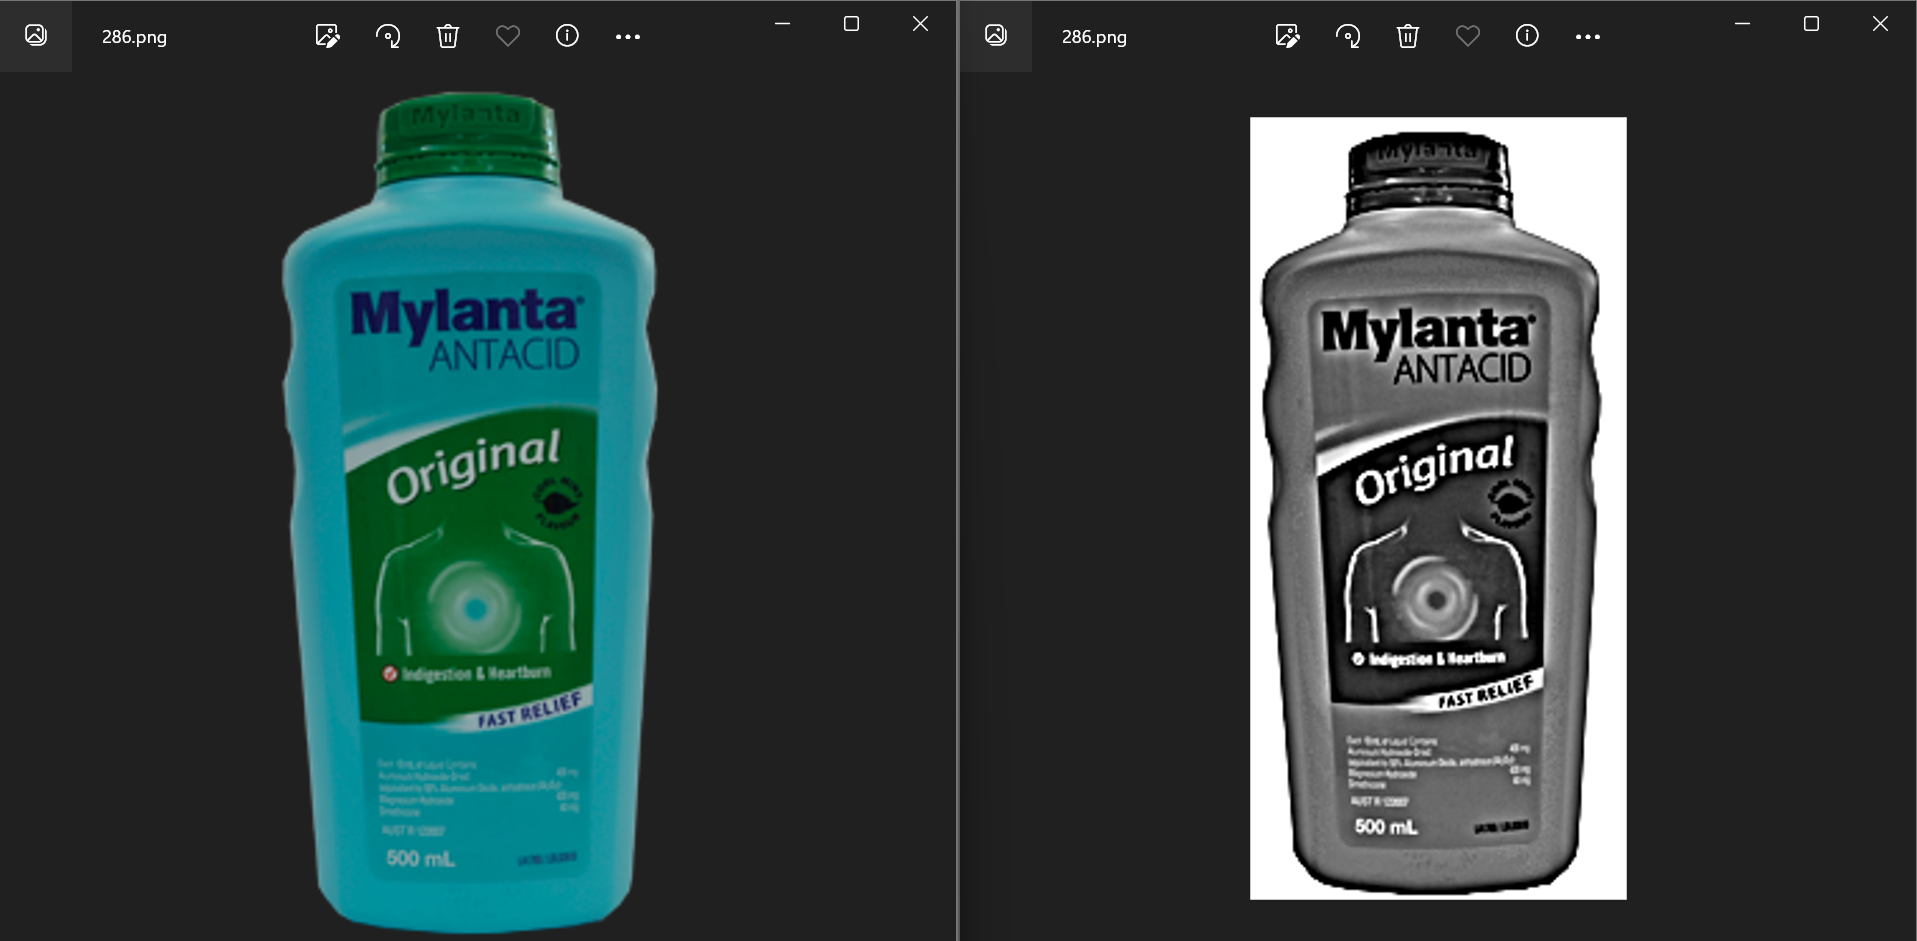
3. I still haven't addressed the lossy compression issue but if you convert it to what the want, it blurs the whole image.


### PERFORMANCE
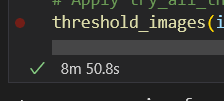 This is for about 2k images

38.214700193423596


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4.845417381917285


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


5.9661865234375


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.030147723846849564


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.863352249362612


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.9432610487035307


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.1437366167023555


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12.485426905932107


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.2588765913889066


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


33.84516457059114


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


19.630519278606965


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.14299900695134063


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4.972424776586344


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.9877429137324727


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.07412500000000001


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.15438988095238096


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.23007045907809265


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.706839690504874


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.12864857982578065


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


49.06367906367906


C:\Users\01157876128\AppData\Local\Temp\ipykernel_22532\3608075756.py:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.array(image).astype(np.float)
C:\Users\01157876128\AppData\Local\Temp\ipykernel_22532\3608075756.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

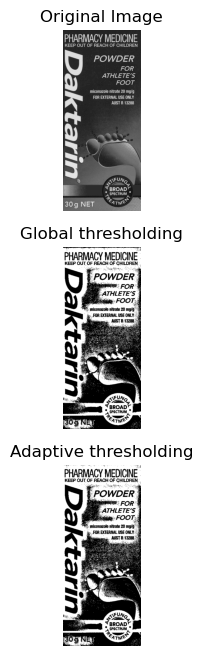

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


2.5756120388158217


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.2543832508250825


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3.9635223458752873


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4.432626306350875


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.5831351840986527


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.1806933421516754


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.0949663201416433


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3.201955048876222


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6.643529438192151


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4.141051912568306


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4.503503297220914


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


9.398407909700096e-05


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


5.568047337278107


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.894048587701964


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0035101677860201715


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0015018484288354898


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.31931330472103003


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.002414540362060327


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3.27520588687296


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.9420742753623189


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.1266


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0003997010236343215


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.03872496874008548


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


29.85248824769006


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.21505376344086022
0.24841781510616906


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.4094670761337428


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.1652452344615014


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.07913896802785692


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


33.27365875026187


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6.913136720829029


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.804218889224718


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.37037362869383916


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3.2286212914485164


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.6962829187523798


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.00024144325117824307


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.039746645480226


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


45.93952136072203


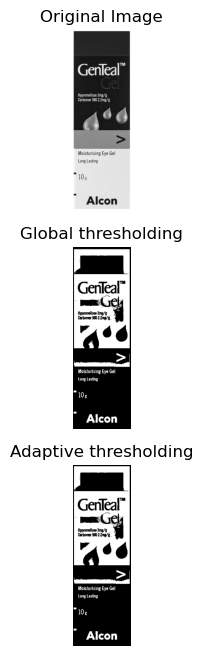

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


15.199096679687498


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


56.08526461432031


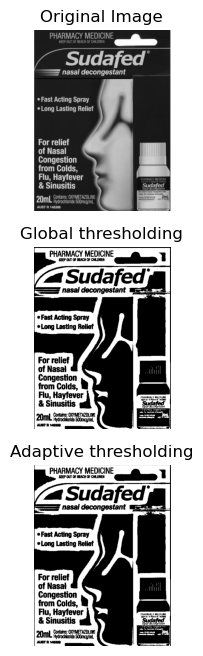

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


0.940989847715736


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.1297916666666667


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


13.659708048628982


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


13.791576086956523


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3.239586500456065


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.037997807818779684


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


16.22701236056678


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


18.90937019969278


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.08844953173777315
0.07139079851930195


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.01281777397991882
2.0809331797235022


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0


KeyboardInterrupt: 

In [6]:
import os
from skimage import io, filters, transform, img_as_ubyte, img_as_float, color
from skimage.filters import unsharp_mask, threshold_local, threshold_otsu
import matplotlib.pyplot as plt
from skimage import data
import cv2
import numpy as np

def threshold_images(input_folder, output_folder, s=None, t=None):
    """ 
    notes: resizing messed up the image pretty badly so i commented it out, 
    this and ignore the lossy compression wearnings, converting the image 
    also destroys most clarity and the results will be very different from what is shown here
    
    This function reads images from the input folder, processes them with thresholding,
    and saves the binarized images to the output folder.
    
    """

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read the image
            img_path = os.path.join(input_folder, filename)
            image = io.imread(img_path, as_gray=True)
            original = io.imread(img_path, as_gray=True)

            # # Resize the image
            # # Calculate the scaling factor to fit within the specified range
            # scale_factor = min(max_width / image.shape[1], max_height / image.shape[0])
            # image = transform.resize(image, (int(image.shape[0] * scale_factor), int(image.shape[1] * scale_factor)))

            # Calculate the number of black pixels
            black_pixels = np.sum(image < 50 / 255.0)  # Convert threshold to range 0-1
            total_pixels = image.size
            black_percentage = black_pixels / total_pixels * 100
            print(black_percentage)

            # Check if the image is majority black
            if black_percentage > 40:
                # # Invert the image by subtracting each pixel value from 255
                # image = 1.0 - image  # Invert the image

                # bradley whatever
                # Convert image to numpy array
                img = np.array(image).astype(np.float)

                # Default window size is round(cols/8)
                if s is None:
                    s = np.round(img.shape[1]/8)

                # Default threshold is 15% of the total
                # area in the window
                if t is None:
                    t = 15.0

                # Compute integral image
                intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

                # Define grid of points
                (rows,cols) = img.shape[:2]
                (X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

                # Make into 1D grid of coordinates for easier access
                X = X.ravel()
                Y = Y.ravel()

                # Ensure s is even so that we are able to index into the image
                # properly
                s = s + np.mod(s,2)

                # Access the four corners of each neighbourhood
                x1 = X - s/2
                x2 = X + s/2
                y1 = Y - s/2
                y2 = Y + s/2

                # Ensure no coordinates are out of bounds
                x1[x1 < 0] = 0
                x2[x2 >= cols] = cols-1
                y1[y1 < 0] = 0
                y2[y2 >= rows] = rows-1

                # Ensures coordinates are integer
                x1 = x1.astype(np.int)
                x2 = x2.astype(np.int)
                y1 = y1.astype(np.int)
                y2 = y2.astype(np.int)

                # Count how many pixels are in each neighbourhood
                count = (x2 - x1) * (y2 - y1)

                # Compute the row and column coordinates to access
                # each corner of the neighbourhood for the integral image
                f1_x = x2
                f1_y = y2
                f2_x = x2
                f2_y = y1 - 1
                f2_y[f2_y < 0] = 0
                f3_x = x1-1
                f3_x[f3_x < 0] = 0
                f3_y = y2
                f4_x = f3_x
                f4_y = f2_y

                # Compute areas of each window
                sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

                # Compute thresholded image and reshape into a 2D grid
                out = np.ones(rows*cols, dtype=np.bool)
                out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

                # Also convert back to uint8
                image = 255*np.reshape(out, (rows, cols)).astype(np.uint8)
                image = 1.0 - image 


            # Apply adaptive thresholding, doing two types here and comparing the performance
            global_thresh = threshold_otsu(image)
            binary_global = image > global_thresh

            block_size = 3
            offset = 0.0000001
            thresh_meth = 'gaussian'
            image = threshold_local(image, block_size, thresh_meth, offset)


            # Apply unsharp masking filter for sharpening
            # Parameters:
            # - radius: The radius of the Gaussian blur used for the unsharp masking (larger values mean stronger blur)
            # - amount: The strength of the sharpening (higher values mean stronger sharpening)
            image = filters.unsharp_mask(image, radius=3, amount=3.5)
            binary_global = filters.unsharp_mask(binary_global, radius=3, amount=3.5)

            if black_percentage > 40:
                # Display the variations
                fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
                ax0, ax1, ax2 = axes
                plt.gray()

                ax0.imshow(original)
                ax0.set_title('Original Image')

                ax1.imshow(binary_global)
                ax1.set_title('Global thresholding')

                ax2.imshow(image)
                ax2.set_title('Adaptive thresholding')

                for ax in axes:
                    ax.axis('off')

                plt.show()
                img = img_as_ubyte(binary_global)
                cv2.imshow("image", img)


            # Save thresholded image to output folder
            output_path = os.path.join(output_folder, filename)
            io.imsave(output_path, image) 

input_folder = 'D:/2024/FYP/codebase/Medication-Dispensing-with-Image-Processing/Medication-Dispensing-with-Image-Processing/Dataset_30-4-2024\clear'
output_folder = 'D:/2024/FYP/codebase/Medication-Dispensing-with-Image-Processing/Medication-Dispensing-with-Image-Processing/Image Pre-Processing/adaptive thresh2'

# Apply try_all_threshold to PNG images in the input folder
threshold_images(input_folder, output_folder)

In [ ]:
import numpy as np
from PIL import Image

def bradley_roth_numpy(image, s=None, t=None):

    # Convert image to numpy array
    img = np.array(image).astype(np.float)

    # Default window size is round(cols/8)
    if s is None:
        s = np.round(img.shape[1]/8)

    # Default threshold is 15% of the total
    # area in the window
    if t is None:
        t = 15.0

    # Compute integral image
    intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

    # Define grid of points
    (rows,cols) = img.shape[:2]
    (X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

    # Make into 1D grid of coordinates for easier access
    X = X.ravel()
    Y = Y.ravel()

    # Ensure s is even so that we are able to index into the image
    # properly
    s = s + np.mod(s,2)

    # Access the four corners of each neighbourhood
    x1 = X - s/2
    x2 = X + s/2
    y1 = Y - s/2
    y2 = Y + s/2

    # Ensure no coordinates are out of bounds
    x1[x1 < 0] = 0
    x2[x2 >= cols] = cols-1
    y1[y1 < 0] = 0
    y2[y2 >= rows] = rows-1

    # Ensures coordinates are integer
    x1 = x1.astype(np.int)
    x2 = x2.astype(np.int)
    y1 = y1.astype(np.int)
    y2 = y2.astype(np.int)

    # Count how many pixels are in each neighbourhood
    count = (x2 - x1) * (y2 - y1)

    # Compute the row and column coordinates to access
    # each corner of the neighbourhood for the integral image
    f1_x = x2
    f1_y = y2
    f2_x = x2
    f2_y = y1 - 1
    f2_y[f2_y < 0] = 0
    f3_x = x1-1
    f3_x[f3_x < 0] = 0
    f3_y = y2
    f4_x = f3_x
    f4_y = f2_y

    # Compute areas of each window
    sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

    # Compute thresholded image and reshape into a 2D grid
    out = np.ones(rows*cols, dtype=np.bool)
    out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

    # Also convert back to uint8
    out = 255*np.reshape(out, (rows, cols)).astype(np.uint8)

### References:

https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding_guide.html

https://stackoverflow.com/questions/33091755/bradley-roth-adaptive-thresholding-algorithm-how-do-i-get-better-performance

https://stackoverflow.com/questions/72555528/how-to-binarize-an-image-when-image-has-white-text-on-black-background-and-vice

#the link above gave me an anuerysm




In [ ]:
%pip install tensorflow

In [ ]:
""" i really hate this """
import tensorflow as tf 
from tensorflow.keras import layers, models

# define input shape, required?

def backbone(input_shape):
    # we use a bunch of CNN, which may need to be refined later
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Additional layers can be added as needed
    return models.Model(input_img, x)

def feature_giant(bbmodel):
    input_features = bbmodel.output
    # upsample
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_features)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    return models.Model(bbmodel.input, x)

# prediction maps
def prediction_maps(feature_giant_model):
    input_img = feature_giant_model.input
    features = feature_giant_model.output

    # Predicted probability map (binary classification)
    prob_map = layers.Conv2D(1, (1, 1), activation='sigmoid', name='prob_map')(features)
    
    # Predicted threshold map
    threshold_map = layers.Conv2D(1, (1, 1), activation='sigmoid', name='threshold_map')(features)
    
    return models.Model(input_img, [prob_map, threshold_map])

def approx_binarization(prob, threshold):
    binarized_map = tf.keras.backend.greater_equal(prob_map, threshold_map)
    return binarized_map

def binmodel(shape):
    # Create the backbone and feature giant models
    backbone_model = backbone(input_shape)
    feature_giant_model = feature_giant(backbone_model)
    
    # Create the prediction maps model
    prediction_maps_model = prediction_maps(feature_giant_model)
    
    # Define the input and outputs
    input_img = prediction_maps_model.input
    prob_map, threshold_map = prediction_maps_model.output
    
    # Calculate the binarized map
    binarized_map = approx_binarization(prob_map, threshold_map)
    
    # Create the final model
    return models.Model(input_img, [prob_map, threshold_map, binarized_map])

input_shape = (128, 128, 3)  # Adjust input shape as needed
model = binmodel(input_shape)

# Compile the model
model.compile(optimizer='adam', loss={'prob_map': 'binary_crossentropy',
                                      'threshold_map': 'mse',
                                      'binarized_map': 'binary_crossentropy'})



In [ ]:
def bounding():
    ''' dbnet algorithm used, with this hopefully we can by pass the binarization problem '''
    pass

def meat():
    pass